In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [2]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [3]:
hdf_dir = Path("../data")

In [4]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [223]:
fname = "2021_6_23.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1624463602 scan R0 F2 F1=3_2 DET                                                 : 1021
1  <> 1624464133 scan R0 F2 F1=3_2 RC ratio with R0 F2 F1=3_2 DET                      : 121
2  <> 1624464183 scan R0 F2 F1=3_2 RC ratio with R0 F2 F1=3_2 DET                      : 41
3  <> 1624464289 scan R0 F2 F1=3_2 RC ratio with R0 F2 F1=3_2 DET                      : 5121
4  <> 1624465628 scan R0 F2 F1=3_2 RC ratio with R0 F2 F1=3_2 DET                      : 4475
5  <> 1624467011  R0 F2 F1=3_2 RC on resonance without DET                             : 601
6  <> 1624472850 scan R0 F2 F1=3_2 DET                                                 : 115
7  <> 1624473021 scan R0 F2 F1=3_2 DET no det multipass                                : 1261
8  <> 1624473437 scan R0 F2 F1=3_2 RC with R0 F2 F1=3_2 DET  no det multipass          : 301
9  <> 1624473537 scan R0 F2 F1=3_2 RC with R0 F2 F1=3_2 DET  no det multipass          : 4961
10 <> 1624474564 scan R0 F2 F1=3_2 RC with R0 F2 F1=3_2 DET  no de

### Detection laser beam is passed through the detection region twice, and then retroflected (going through a $\lambda/4$) for another two passes. Laser is elliptically expanded in height.

### All with phase modulation on detection

## Scan R0 F=2 F1'=3/2
43 mW

In [6]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [8]:
dset_idx = 0
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

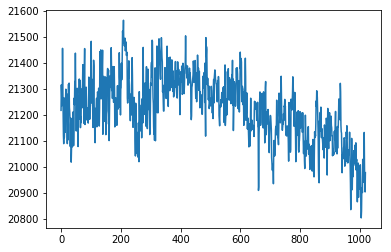

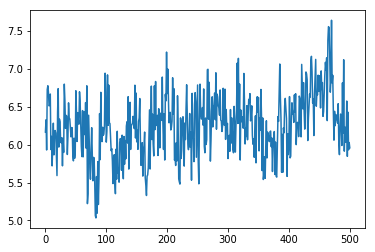

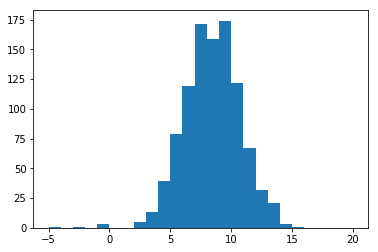

In [9]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [10]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [11]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

6.1% data discarded


In [12]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

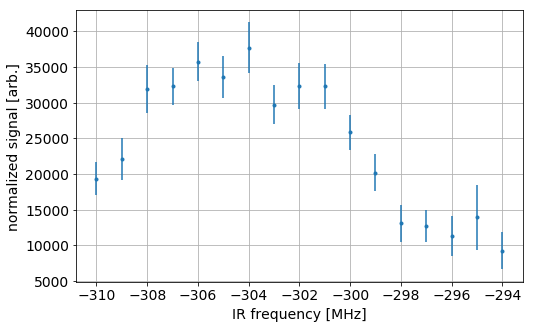

In [13]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
65 mW RC  
43 mW DET

In [23]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [24]:
dset_idx = 3
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

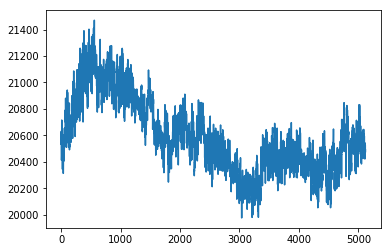

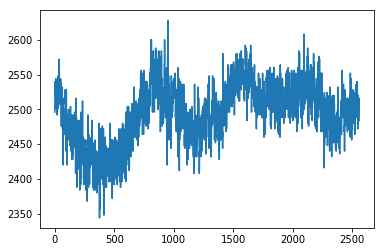

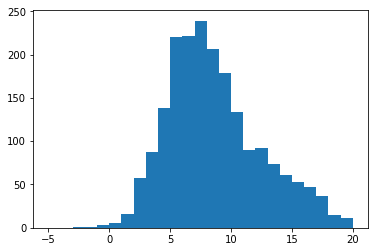

In [25]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [26]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 1900

In [27]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

11.7% data discarded


In [28]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

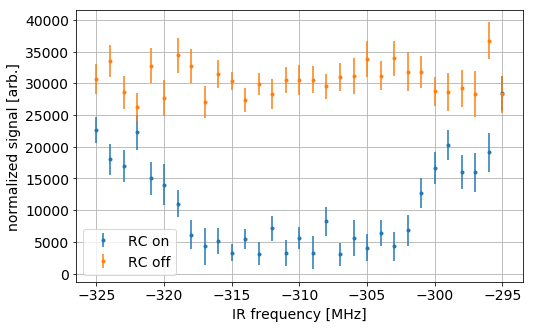

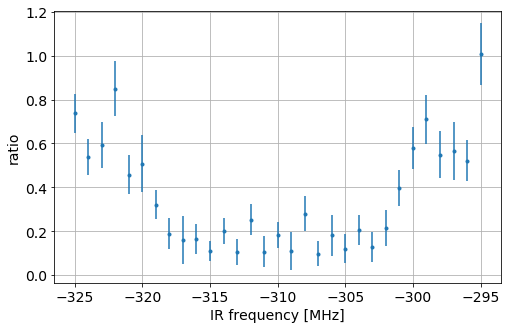

In [29]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
5 mW RC  
43 mW DET

In [42]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [49]:
dset_idx = 4
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

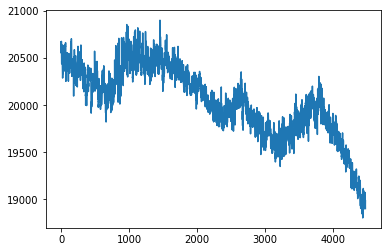

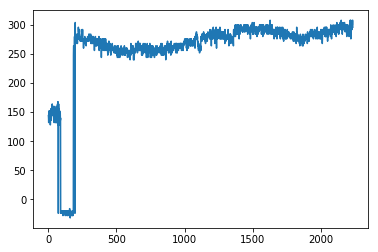

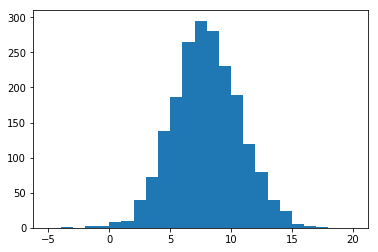

In [50]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [51]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 200

In [52]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

22.6% data discarded


In [53]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

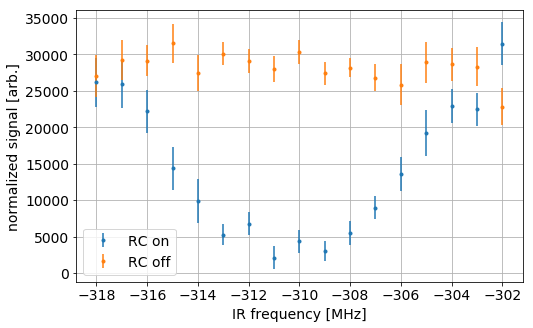

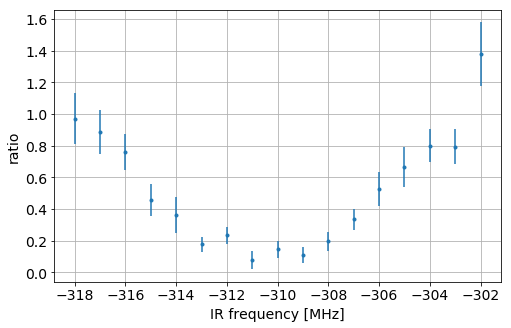

In [54]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
74 mW RC  
0 mW DET

In [58]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [59]:
dset_idx = 5
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

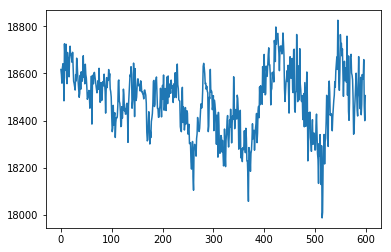

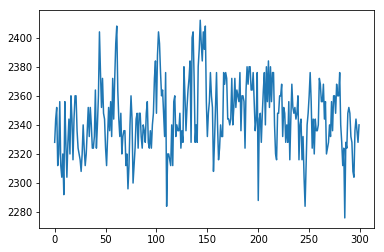

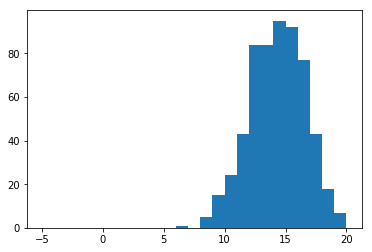

In [60]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [62]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 2000

In [63]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.7% data discarded


In [67]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    mt = m
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))

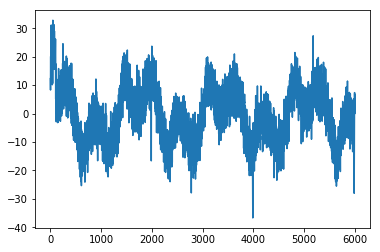

In [76]:
plt.plot(np.nanmean(pmt_data_norm[mask_sh_open], axis = 0))

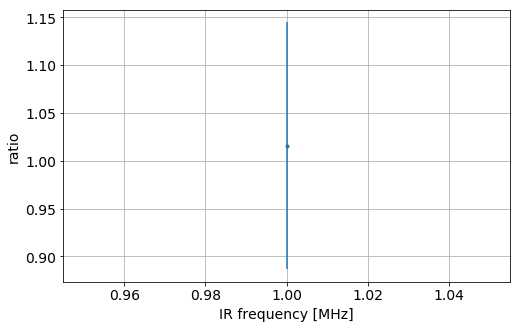

In [70]:
ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(1, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

### No multipass or beam expansion on DET
### beam is not collimated nicely, expanded slightly (guestimate 5mm size)

### All with phase modulation on detection

## Scan R0 F=2 F1'=3/2
43 mW

In [78]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [80]:
dset_idx = 7
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

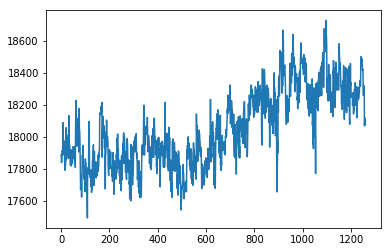

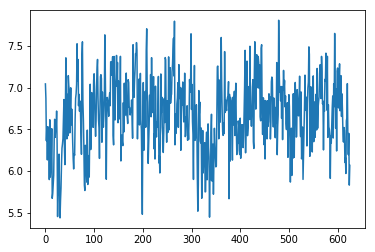

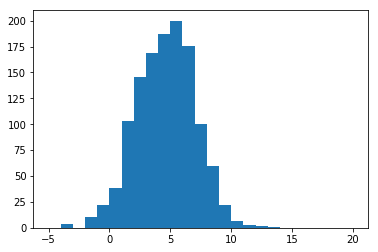

In [81]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [82]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [83]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

54.0% data discarded


In [84]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

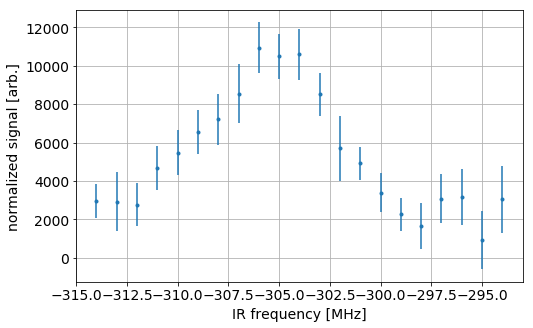

In [85]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
75 mW RC  
43 mW DET

In [87]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [88]:
dset_idx = 9
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

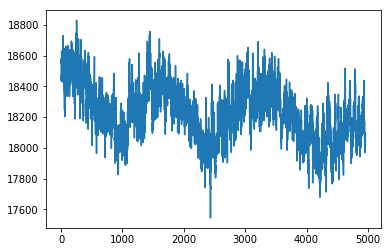

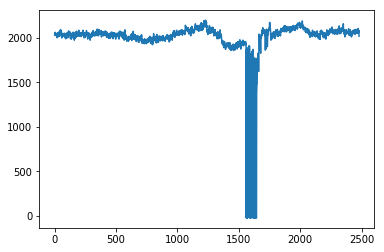

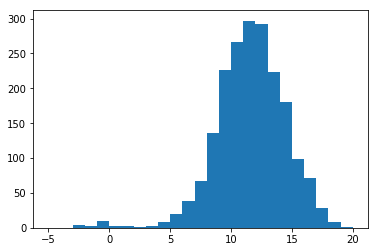

In [89]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [90]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 200

In [91]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

2.3% data discarded


In [92]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

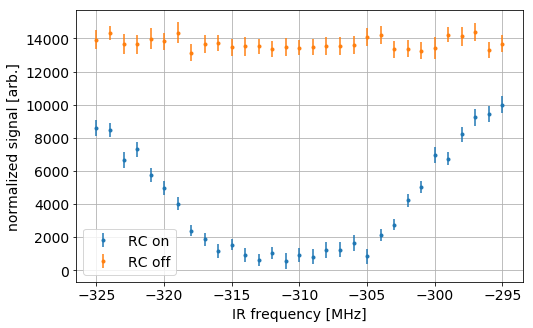

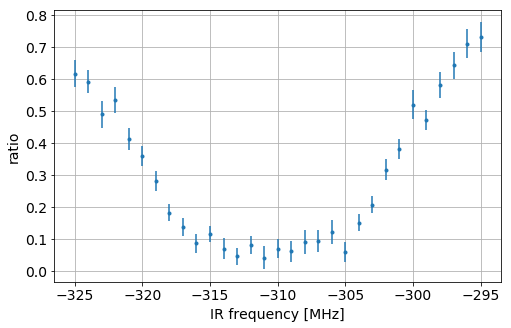

In [93]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
75 mW RC  
43 mW DET
 
Iris to make DET beam smaller

In [98]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [120]:
dset_idx = 10
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

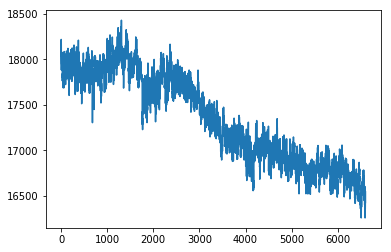

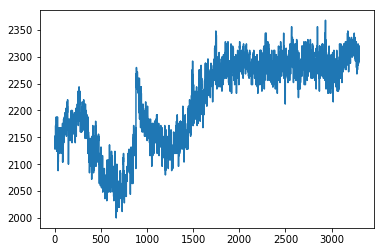

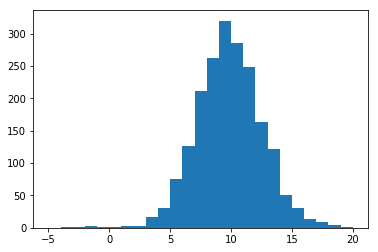

In [121]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [122]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 200

In [123]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

4.0% data discarded


In [124]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

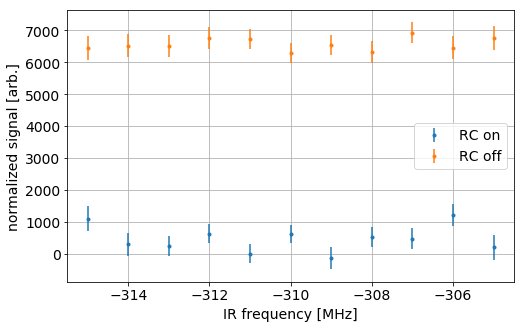

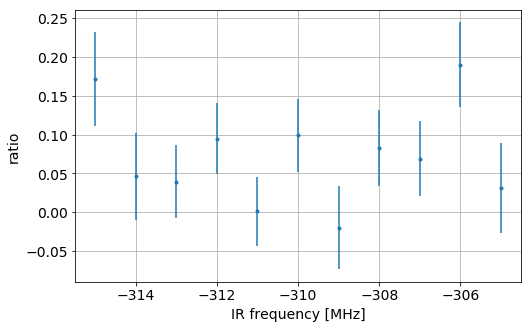

In [125]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [128]:
np.mean(ratio[3:-3])

0.0515451610959608

In [129]:
np.sqrt(np.sum(err[3:-3]**2)/len(err[3:-3]))

0.047994336146942894

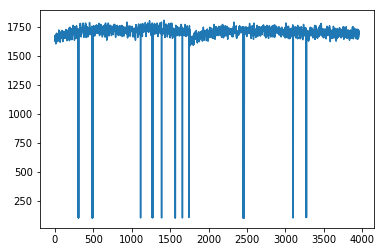

In [118]:
plt.plot(yag_data.max(axis = 1)) 

In [119]:
np.sum(yag_data.max(axis = 1) < 200)

26

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
75 mW RC  
43 mW DET
 
Iris to make DET beam smaller  
YAG not fired; background check

In [98]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [131]:
dset_idx = 11
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

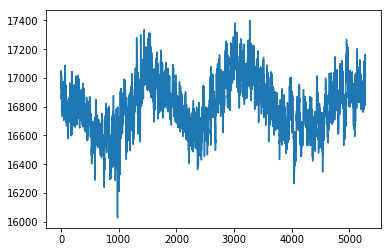

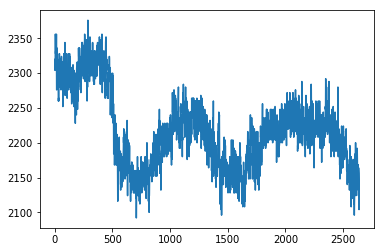

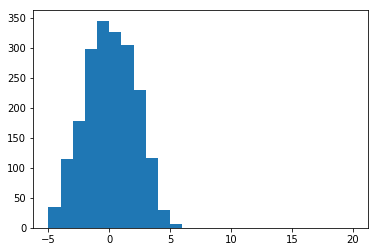

In [132]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [133]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 200

In [134]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_pdn | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.0% data discarded


In [140]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

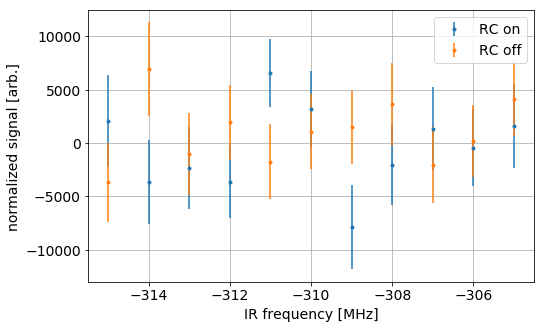

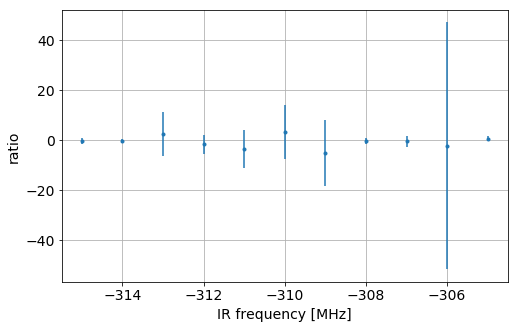

In [141]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
75 mW RC  
43 mW DET
 
Iris to make DET beam smaller  
PMT -1200V

In [213]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [214]:
dset_idx = 12
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

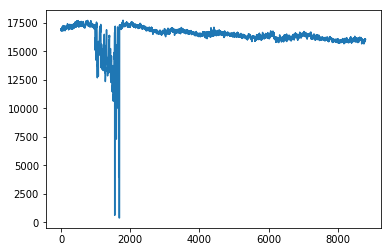

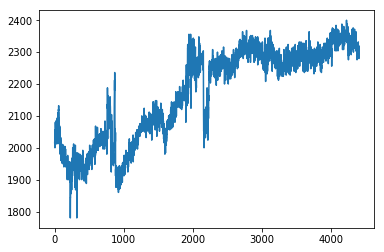

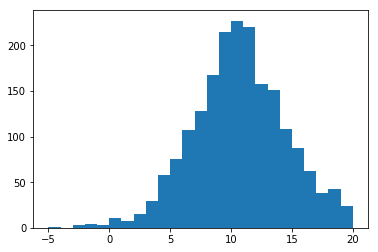

In [215]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [216]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 200

In [217]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

10.8% data discarded


In [218]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

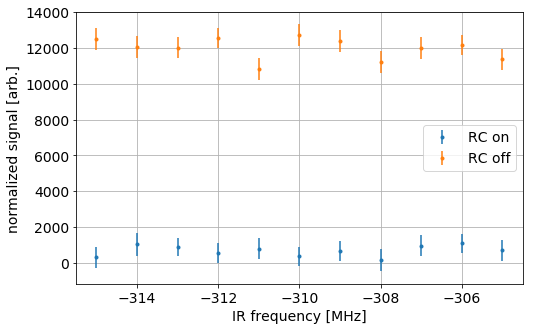

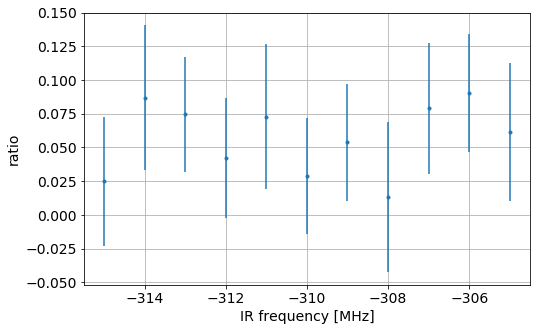

In [219]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [220]:
mr = np.mean(ratio[3:-3])
me = np.sqrt(np.sum(err[3:-3]**2)/len(err[3:-3]))
print(f"{mr:.3f} +/- {me:.3f}")

0.042 +/- 0.049


In [221]:
mr = np.mean(ratio)
me = np.sqrt(np.sum(err**2)/len(err))
print(f"{mr:.3f} +/- {me:.3f}")

0.057 +/- 0.048


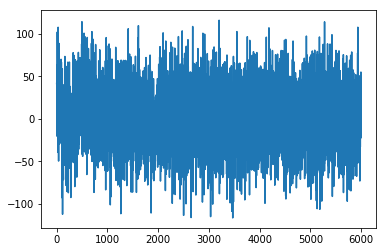

In [222]:
m = scan_parameters == -310
plt.plot(np.nanmean(pmt_data_norm[m & mask_sh_open], axis = 0))

## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
74 mW RC  
43 mW DET
 
Iris to make DET beam smaller  
PMT -1200V

In [194]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [231]:
dset_idx = 13
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

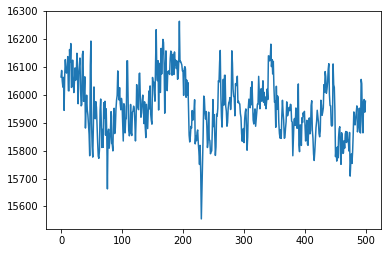

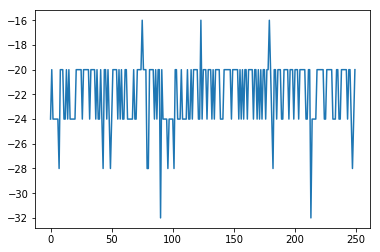

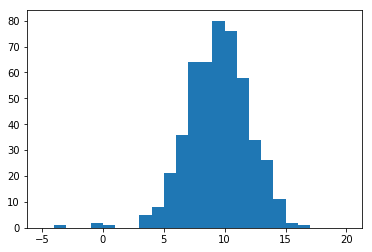

In [232]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [233]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 200

In [234]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

5.4% data discarded


In [235]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

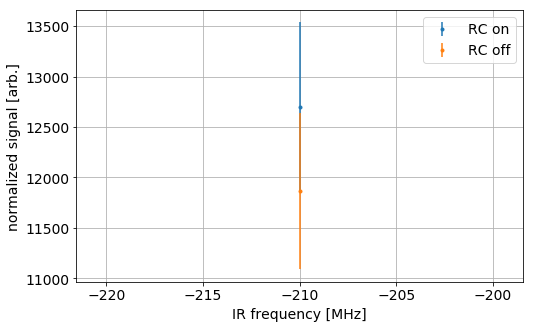

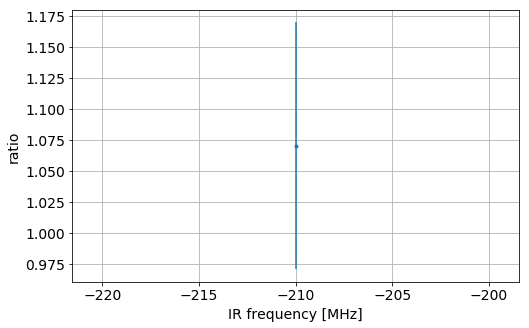

In [236]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [237]:
mr = np.mean(ratio)
me = np.sqrt(np.sum(err**2)/len(err))
print(f"{mr:.3f} +/- {me:.3f}")

1.070 +/- 0.100


## Scan R0 F2 F1=3/2 RC ratio with R0 F2 F1=3/2 DET
74 mW RC  
43 mW DET
 
Iris to make DET beam smaller  
PMT -1200V

In [238]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [239]:
dset_idx = 14
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

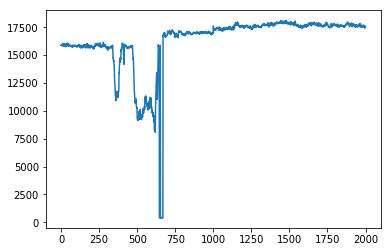

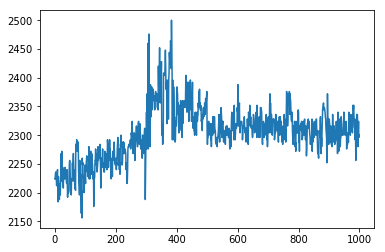

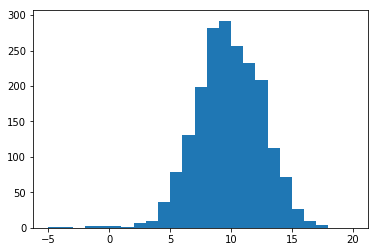

In [240]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.min(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [241]:
yag_cutoff = 250
ptn_cutoff = 15000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 200

In [242]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < pdrc_cutoff) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > pdrc_cutoff) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

15.4% data discarded


In [243]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

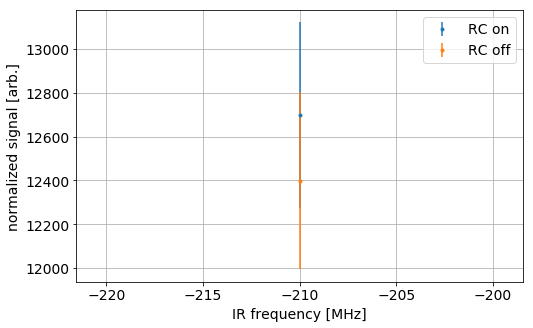

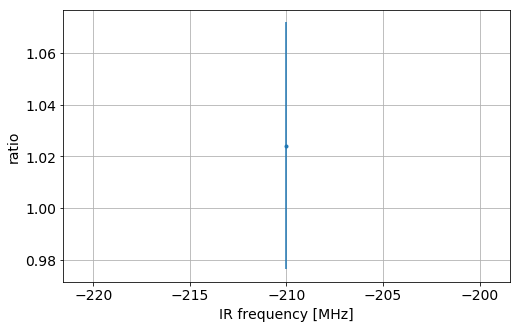

In [244]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [245]:
mr = np.mean(ratio)
me = np.sqrt(np.sum(err**2)/len(err))
print(f"{mr:.3f} +/- {me:.3f}")

1.024 +/- 0.048
